First up, a data generating process that should be pretty hard to guess at:

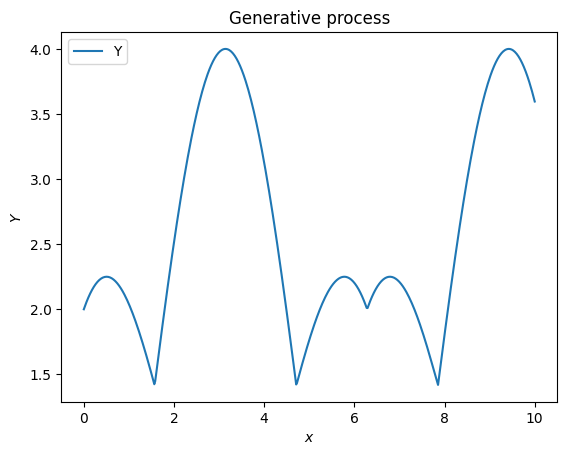

In [1]:
import numpy as np

X = np.linspace(start=0, stop=10, num=500)
X2 = np.squeeze(X + (2 * abs(np.cos(X))))
X3 = np.squeeze(X - (2 * abs(np.sin(X / 2))))

y = np.subtract(X2, X3)
#y = np.subtract(y, X3)

import matplotlib.pyplot as plt

plt.plot(X, y, label=r"Y")
# plt.plot(X, X2, label=r"X2", linestyle="dotted")
# plt.plot(X, X3, label=r"X3", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$Y$")
_ = plt.title("Generative process")

Pick 10 points that our GPR will guess at:

In [2]:
rng = np.random.RandomState(42)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)

Xs = np.array([X,X2,X3]).transpose()

X_train = [[],[],[]]

for ind in training_indices:
    X_train[0].append(X[ind])
    X_train[1].append(X2[ind])
    X_train[2].append(X3[ind])

X_train = np.array(X_train).transpose()

y_train = y[training_indices]

Now train using the RBF kernel:

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
#kernel = 1 * RBF(length_scale=1.0)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


47**2 * RBF(length_scale=100)

Now predict using our GPR

In [4]:
mean_prediction, std_prediction = gaussian_process.predict(Xs, return_std=True)

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


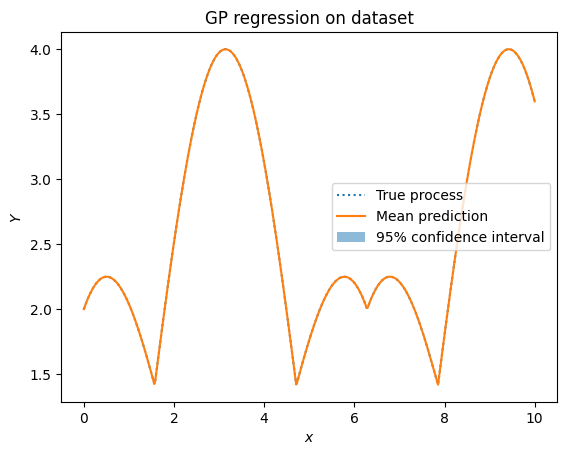

In [ ]:

plt.plot(X, y, label=r"True process", linestyle="dotted")
plt.scatter(X_train.transpose()[0], y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$Y$")
_ = plt.title("GP regression on dataset")

So it nails it. Now let's add noise.

In [7]:
noise_std = 0.25
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)


In [9]:
# retrain

gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(Xs, return_std=True)

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


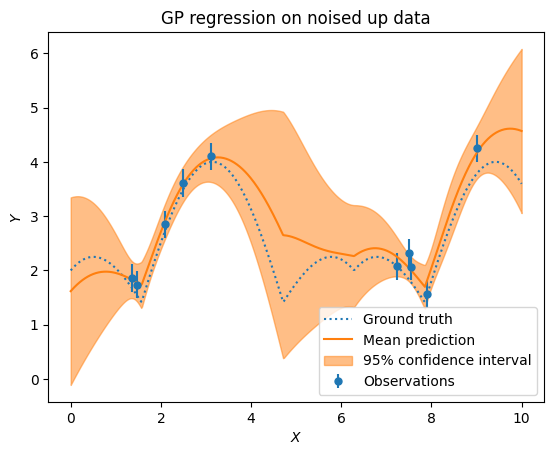

In [11]:
plt.plot(X, y, label=r"Ground truth", linestyle="dotted")
plt.errorbar(
    X_train.transpose()[0],
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$X$")
plt.ylabel("$Y$")
_ = plt.title("GP regression on noised up data")